In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(123)
from matplotlib import style
style.use('classic')
import statsmodels.api as sm
import pandas as pd
import os


In [3]:
class Config:
    # データの入出力
    output_dir = r'semi_documents\whole seminar\collider bias'
    # 何か指定しない方が良さそう。notebookにおけるcwdは.ipynbのあるdirらしい...。

    # 標本数
    N = 100
    marker_size = 40

    # 交絡の例に関する設定  
    BOD_mean = 5
    BOD_sigma = 3
    biodiversity_sigma = 5 # 同じBOD濃度の河川において+-５種
    biodiversity_beta_1 = -2.0
    biodiversity_beta_0 = 20
    zinc_sigma = 1 # 同じBOD濃度の河川において+- 5(ug/L)
    zinc_beta_1 = 2
    zinc_beta_0 = 5


# Collider Bias in data collection(環境補助金制度)

In [4]:
# 標本数(the num of sample companies)
N = 5000

# まずは「CO2 emission」「TMR」のデータを生成
# それぞれの能力値を平均ゼロ、標準偏差1の正規分布に従いランダムに生成
# 両データは平均0標準偏差1に標準化されている、という想定
co2_emission = np.random.normal(loc=0.0, scale=1.0, size=N)
total_material_requirement = np.random.normal(loc=0.0, scale=1.0, size=N)

# 次に「CO2 emission」と「TMR」から「環境負荷量の評価値(env_burden_eval)」を算出
env_burden_eval = 0.5 * co2_emission + 0.5 * total_material_requirement

# env_burden_evalの上位15%(小さい方が良い)に補助金subsidyを認める
standard_value = np.percentile(env_burden_eval, q=15)  # 15%値を取得
print(standard_value)
# if (env_burden_eval <= standard_value) =>receive subsidy = 1, else = 0
receive_subsidy = np.where(env_burden_eval <= standard_value, 1, 0)

# 生成したデータをDataFrameにまとめる
df_subsidy_program = pd.DataFrame(
    data={
        "co2_emission": co2_emission,
        "total_material_requirement": total_material_requirement,
        "env_burden_eval": env_burden_eval,
        "receive_subsidy":receive_subsidy
    }
)
df_subsidy_program.head()


-0.7311995556643489


,co2_emission,total_material_requirement,env_burden_eval,receive_subsidy
0,-1.085631,0.318764,-0.383434,0
1,0.997345,1.511104,1.254225,0
2,0.282978,-1.136627,-0.426824,0
3,-1.506295,0.642460,-0.431917,0
4,-0.578600,-1.127882,-0.853241,1


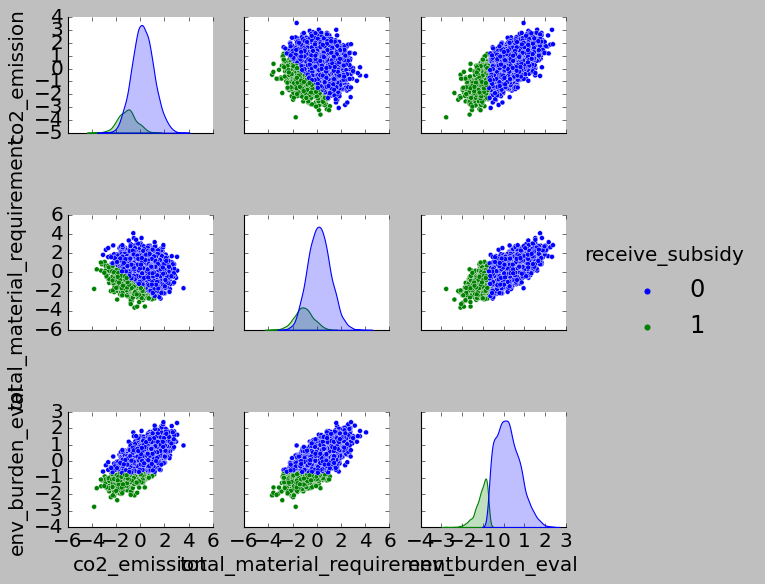

In [5]:
plt.rcParams["font.size"] = 18
# データの様子を直感的に理解するために、まずはペアプロットを描いてみる
pair_plot = sns.pairplot(
    df_subsidy_program,
    hue='receive_subsidy' # change color by this column's value
    )

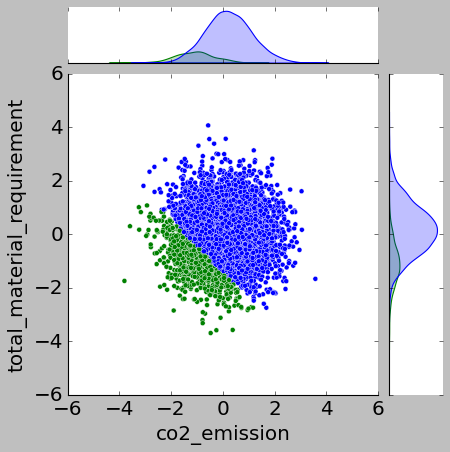

In [6]:
plt.rcParams["font.size"] = 18
# 散布図
scatter_plot = sns.jointplot(
    x='co2_emission', 
    y='total_material_requirement',
    data=df_subsidy_program,
    hue='receive_subsidy',
    legend=False,
    palette=["blue", "green"]
)

plt.savefig('CO2_x_TMR_y.png')

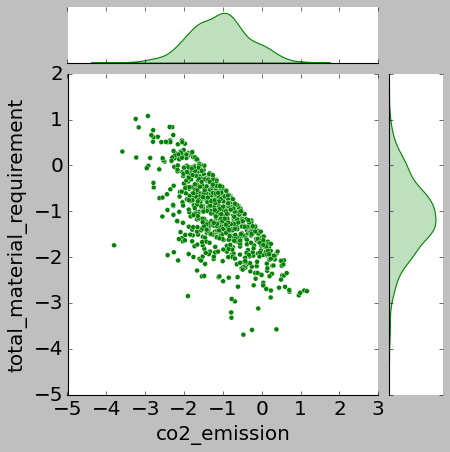

In [7]:
# the example of collider bias in data sellection(=sellection bias)

# data sellected in collider
select_mask = df_subsidy_program['receive_subsidy'] == 1
df_subsidy_program_selected = df_subsidy_program[select_mask].copy()
# plot
scatter_plot = sns.jointplot(
    x='co2_emission', 
    y='total_material_requirement',
    data=df_subsidy_program_selected,
    hue='receive_subsidy',
    legend=False,
    palette=["green"]
)
plt.savefig('CO2_x_TMR_y_selected.png')

# Collider Bias（トライアスロンの例）


In [70]:
np.random.seed(123)
# set the num of sample data
N = 5000

# Firstly generated data of 'bike_ability', 'run_ability','swim_ability'
# Each abilities are generated by Normal distribution of mu=0.0 & sigma=1.0
bike_ability = np.random.normal(loc=0.0, scale=1.0, size=N)
run_ability = np.random.normal(loc=0.0, scale=1.0, size=N)
swim_ability = np.random.normal(loc=0.0, scale=1.0, size=N)

# Secondly, 'duathlon_times' is generated by 'bike_ability', 'run_ability'
# generate error term for 'duathlon_time'
error_1 = np.random.normal(loc=0, scale=1.0, size=N)
# we set 'duathlon_times' ＝ -0.8×'bike_ability' - 1.5×'run_ability'＋ error term
duathlon_times = -0.8 * bike_ability - 1.5 * run_ability + error_1

# Thirdly、'duathlon_times' is generated by 'bike_ability', 'run_ability', 'swim_ability'
# generate error term for 'triathlon_time'
error_2 = np.random.normal(loc=0, scale=1.0, size=N)
# we set 'duathlon_times' ＝ -1.0×'bike_ability' - 0.8×'run_ability' -0.8＋ error term
triathlon_time = -1 * bike_ability - 0.8 * run_ability - 0.8 * swim_ability + error_2

# Integrate all data we generated as a DataFrame
df_du_tri = pd.DataFrame(
    data={
        'bike_ability':bike_ability,
        'run_ability':run_ability,
        'swim_ability':swim_ability,
        'duathlon_time':duathlon_times,
        'triathlon_time':triathlon_time
    }
)

# check the content of DataFrame
df_du_tri.head()

,bike_ability,run_ability,swim_ability,duathlon_time,triathlon_time
0,-1.086,0.319,-1.241,1.298,2.855
1,0.997,1.511,-0.313,-1.379,-0.624
2,0.283,-1.137,-0.849,0.362,1.401
3,-1.506,0.642,2.378,0.395,0.008
4,-0.579,-1.128,0.658,2.210,-1.054


Each column represents data values for BIKE_ABILITY, RUN_ABILITY, SWIM_ABILITY, DUATHLON_TIME, and TRIATHLON_TIME.

Each row represents an individual record, and this data contains 5000 rows (=5000 individuals) in total.

The data is now ready!

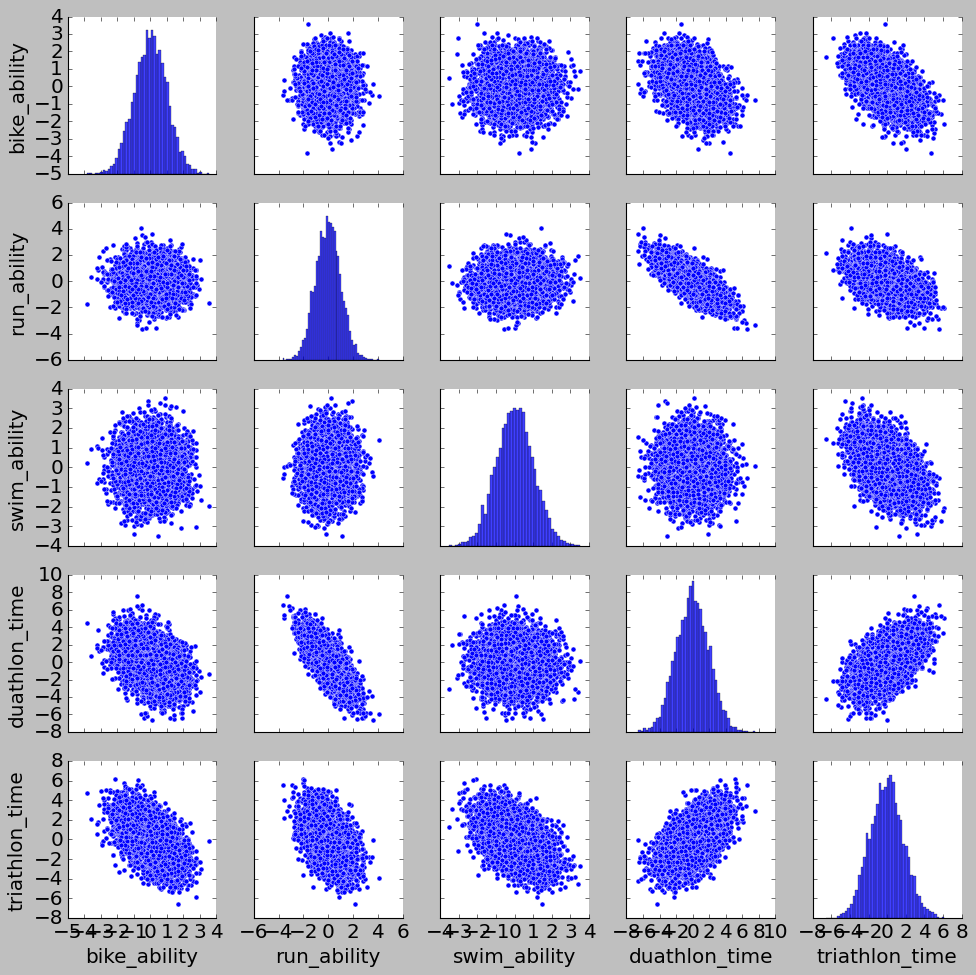

In [71]:
plt.rcParams["font.size"] = 18
# データの様子を直感的に理解するために、まずはペアプロットを描いてみる
target_cols = ['bike_ability', 'run_ability', 'swim_ability','duathlon_time','triathlon_time']
pair_plot = sns.pairplot(df_du_tri[target_cols])

plt.savefig('triathlon_pairplots.png')

これらの散布図を見ると、「自転車力」「走力」と「デュアスロンタイム」「トライアスロンタイム」との間には負の相関が見られます。一方、「自転車力」と「走力」の間には相関が見られません。これは各データの生成における仮定／過程と整合しており、何ら不思議のないもの。

In [72]:
from typing import List

from sympy import residue


def estimate_sigma_square(y:np.ndarray, X:np.ndarray, a:List[float])->float:
    
    num_explanatory_var = len(a)
    # calc y_hat 
    y_hat = np.zeros(shape=y.shape[0])
    for i in range(num_explanatory_var):
        a_i = a[i]

        X_i = X[:,i]
        a_i_times_X_i = X_i * a_i
        y_hat += a_i_times_X_i
    
    # calc residue(残差e) = y - y_hat
    print(f'y shape is {y.shape}')
    print(f'y_hat shape is {y_hat.shape}')

    residue_array:np.ndarray = y[:,0] - y_hat
    print(f'residue_array shape is {residue_array.shape}')

    # innor products(内積) of residue_array(= residue_arrayのノルム(長さ)の2乗)
    square_residue_array = np.dot(residue_array, residue_array)
    # calc \hat{\sigma^2}
    n_samples = y.shape[0]
    sigma_square_hat_OLS = square_residue_array/(n_samples - num_explanatory_var)
    return sigma_square_hat_OLS
    


In [73]:
# では回帰分析
# もともとの目的は「自転車力がデュアスロンタイムに与える影響」を見ること
# デュアスロンタイム」を目的変数、「自転車力」を説明変数にして単回帰分析
# （モデル式：デュアスロンタイム＝A×自転車力＋B）：

X_columns = ['bike_ability']
y_columns = ['duathlon_time']

X = df_du_tri[X_columns].values
X = sm.add_constant(data=X) # constant termを追加
y = df_du_tri[y_columns].values

model = sm.OLS(y, X)
res = model.fit()
print(res.summary())
print(res.aic)
sigma_square_hat = estimate_sigma_square(y,X, a=res.params)
print(sigma_square_hat)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     936.7
Date:                Sat, 16 Jul 2022   Prob (F-statistic):          1.05e-188
Time:                        15:24:14   Log-Likelihood:                -10084.
No. Observations:                5000   AIC:                         2.017e+04
Df Residuals:                    4998   BIC:                         2.018e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.026     -0.099      0.9

解析結果から、「自転車力」の回帰係数は「-0.53」と推定されており、これはデータ生成時の関係式における係数「-0.5」と近い値になっています。

つまり、ここでは「自転車力」のみを説明変数とした単回帰により、「自転車力→デュアスロンタイム」の因果効果は適切に推定されています。この例のような因果構造の場合には、単回帰が「必要にして充分」なのです*14。

In [74]:
# では、このケースに対して重回帰分析を行ってみましょう

X_columns = ['bike_ability', 'triathlon_time']
y_columns = ['duathlon_time']

X = df_du_tri[X_columns].values
X = sm.add_constant(data=X) # constant termを追加
y = df_du_tri[y_columns].values

res = sm.OLS(y, X).fit()
print(res.summary())

print(res.aic)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     1235.
Date:                Sat, 16 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:24:14   Log-Likelihood:                -9509.5
No. Observations:                5000   AIC:                         1.902e+04
Df Residuals:                    4997   BIC:                         1.904e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.023      0.664      0.5

In [75]:
res.params
res.aic

19024.932979250098

In [76]:
# Compare the modeling results(AIC, a_1) with each candidates of explanatory variables
from re import A

candidates_explanatory_variables = [
    ["bike_ability"],
    ["bike_ability", "triathlon_time"],
    ["bike_ability", "triathlon_time", "run_ability"],
    ["bike_ability", "run_ability"],
    ["bike_ability", "triathlon_time", "swim_ability"],
    ["bike_ability", "swim_ability"],
]
explained_variable = ["duathlon_time"]
a_1_actual = -0.8

# Initialize the empty list for saving results(AIC and a_1 of each model)
aic_list = []
a_1_list = []
diff_a_1_list = []

for explanatory_variables in candidates_explanatory_variables:
    # get the values of explanatory variables
    X = df_du_tri[explanatory_variables].values
    X = sm.add_constant(data=X)  # add constant term
    # get the values of explained variable
    y = df_du_tri[explained_variable].values

    res = sm.OLS(y, X).fit()
    # get aic
    aic = res.aic
    # get a_1(regression coefficient of 'bike_ability')
    a_1_estimated = res.params[1]
    # save the results to the list
    aic_list.append(aic)
    a_1_list.append(a_1_estimated)
    diff_a_1_list.append(abs(a_1_actual - a_1_estimated))

# summarize the results of each candidates

df_results = pd.DataFrame(
    data={
        "explanatory_variables": candidates_explanatory_variables,
        "AIC": aic_list,
        "a_1(estimated causal effect)": a_1_list,
        "diff_a_1_actual_with_estimated": diff_a_1_list
    }
)
df_results.astype({"AIC":int})
pd.options.display.precision = 3
df_results

,explanatory_variables,AIC,a_1(estimated causal effect),diff_a_1_actual_with_estimated
0,[bike_ability],20171.746,-0.797,0.003
1,"[bike_ability, triathlon_time]",19024.933,-0.255,0.545
2,"[bike_ability, triathlon_time, run_ability]",14229.184,-0.805,0.005
3,"[bike_ability, run_ability]",14228.249,-0.794,0.006
4,"[bike_ability, triathlon_time, swim_ability]",18506.423,-0.041,0.759
5,"[bike_ability, swim_ability]",20172.309,-0.796,0.004


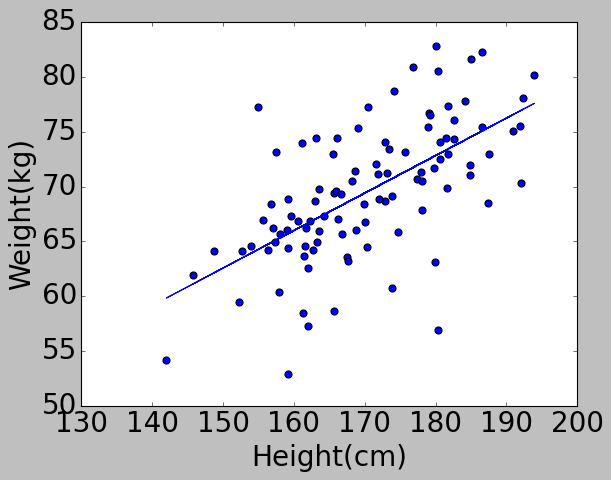

In [60]:
# 描画
# 疑似データ
plt.scatter(h, w, s=40, marker='o')
plt.xlabel('Height(cm)')
plt.ylabel('Weight(kg)')
# Linear Regression line
plt.plot(h, res.fittedvalues, label='Linear Regression Line')
# add error term on the LR line
# plt.fill_between(
#     h, y1=res.fittedvalues+1, y2=res.fittedvalues-1, color='#888888', 
#     alpha=0.4
# )
# add model formula in figure
# plt.text(x=170, y=60, 
#     s='weight = {:.3f} + {:.3f} * height + epsilon'
# .format(res.params[0], res.params[1]),
# ha='center')


# The case of Confounding


(100,) (100,) (100,)


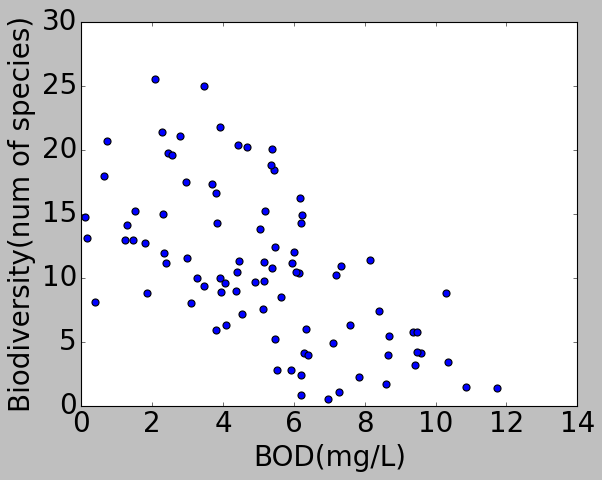

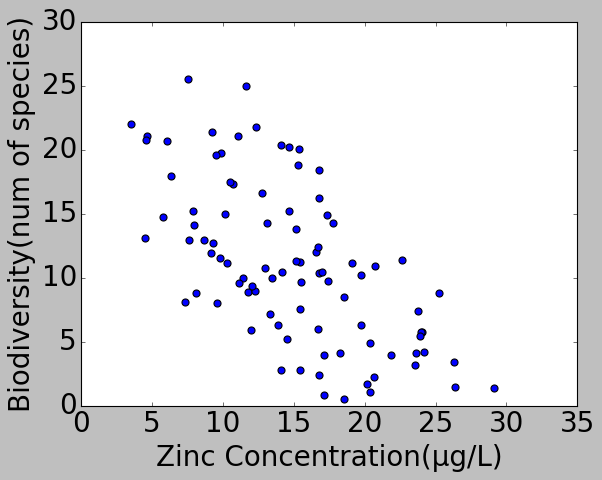

In [61]:
plt.rcParams["font.size"] = 25

# 疑似データ生成
# BOD濃度
np.random.seed(0)
BOD =np.random.normal(loc=Config.BOD_mean,
scale=Config.BOD_sigma,
size=Config.N)

# Biodiversity
biodiversity = (Config.biodiversity_beta_0 
+ Config.biodiversity_beta_1 * BOD 
+ np.random.normal(loc=0, scale=Config.biodiversity_sigma
, size=N)
)

# zinc concentration
zinc = (Config.zinc_beta_0
+ Config.zinc_beta_1*BOD 
+ np.random.normal(loc=0, scale=Config.zinc_sigma, size=N)
)

# check the array size
print(BOD.shape, biodiversity.shape, zinc.shape)

# scatter plot of each two factors
plt.scatter(BOD, biodiversity, s=40, marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('BOD(mg/L)')
plt.ylabel('Biodiversity(num of species)')
plt.show()

plt.scatter(zinc, biodiversity, s=40, marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Zinc Concentration(μg/L)')
plt.ylabel('Biodiversity(num of species)')
plt.show()


## zinc-biodiversity

In [62]:
# Linear Regression models
# x= height, y= weight
X= sm.add_constant(zinc)
y= biodiversity
model = sm.OLS(y, X)
res_only_zinc_correlation = model.fit()
print(res_only_zinc_correlation.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     102.5
Date:                Sun, 15 May 2022   Prob (F-statistic):           6.51e-17
Time:                        16:57:59   Log-Likelihood:                -307.67
No. Observations:                 100   AIC:                             619.3
Df Residuals:                      98   BIC:                             624.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3100      1.413     16.499      0.0

biodiversity = 23.31 + -0.87 * zinc + epsilon


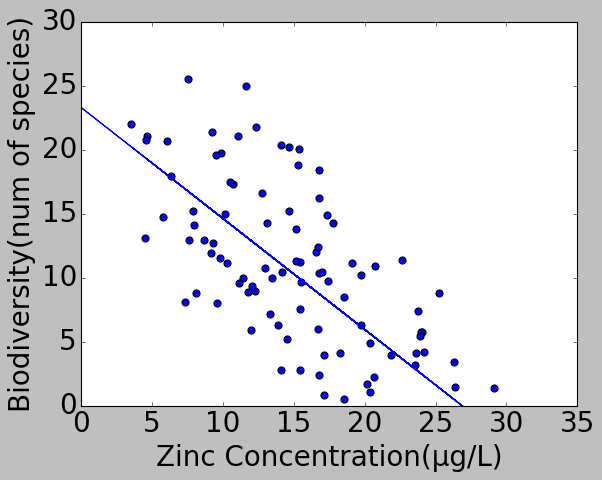

In [63]:
# 描画
res = res_only_zinc_correlation
# 疑似データ
plt.scatter(zinc, biodiversity, s=40, marker='o')
# Linear Regression line
plt.plot(zinc, res.fittedvalues, label='Linear Regression Line')

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Zinc Concentration(μg/L)')
plt.ylabel('Biodiversity(num of species)')

# plt.text(x=10, y=30, 
#     s='biodiversity = {:.3f} + {:.3f} * zinc + epsilon'
# .format(res.params[0], res.params[1]),
# )
print('biodiversity = {:.2f} + {:.2f} * zinc + epsilon'
.format(res.params[0], res.params[1]))

## BOD-biodiversity

In [69]:
# Linear Regression models
# x= height, y= weight
X= sm.add_constant(BOD)
y= biodiversity
model = sm.OLS(y, X)
res_BOD_biodiversity = model.fit()
print(res_BOD_biodiversity.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     110.9
Date:                Sun, 15 May 2022   Prob (F-statistic):           8.52e-18
Time:                        16:58:28   Log-Likelihood:                -305.62
No. Observations:                 100   AIC:                             615.2
Df Residuals:                      98   BIC:                             620.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.4199      1.030     18.853      0.0

biodiversity = 19.42 + -1.81 * BOD + epsilon


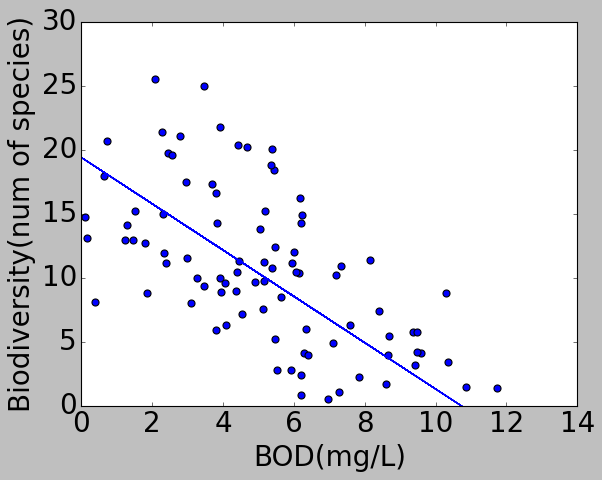

In [71]:
# 描画
res = res_BOD_biodiversity
# 疑似データ
plt.scatter(BOD, biodiversity, s=40, marker='o')
# Linear Regression line
plt.plot(BOD, res.fittedvalues, label='Linear Regression Line')

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('BOD(mg/L)')
plt.ylabel('Biodiversity(num of species)')

print('biodiversity = {:.2f} + {:.2f} * BOD + epsilon'
.format(res.params[0], res.params[1]))

## Zinc-biodiversity considering BOD

In [72]:
# Linear Regression models
X = np.column_stack(tup=(zinc, BOD))
X= sm.add_constant(X)
y= biodiversity
model = sm.OLS(y, X)
res_Zinc_BOD_biodiversity = model.fit()
print(res_Zinc_BOD_biodiversity.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     55.13
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.02e-16
Time:                        17:02:52   Log-Likelihood:                -305.50
No. Observations:                 100   AIC:                             617.0
Df Residuals:                      97   BIC:                             624.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.1686      2.841      6.396      0.0